Reminder: when running this notebook use conda activate my-rdkit-env in miniconda

# RDKIT overview

# major types of moleculer file formats
* SMILES -- plain text (string) [more description ](http://www.daylight.com/dayhtml/doc/theory/theory.smiles.html)
* sdf    -- plain text (acom coordinates)

## SMILES

Simplest way to reflect a molecule:
* atoms of chemical elements are represented by chemical symbols in capital letter, hydrogen is usually ignored. 
* bonds :
    * single bonds are not displayed 
    * for double '=' symbol
    * for triple '#' symbol
    * for quadruple '$' symbol 
* atoms that are bonded must stand nearby.
Ring structures are written by breaking each ring at an arbitrary point (although some choices will lead to a more legible SMILES than others) to make a 'straight non-ring' structure (as if it wasn't a ring) and adding numerical ring closure labels to show connectivity between non-adjacent atoms.
* aromacity is commonly illustrated by writing the constituent B, C, N, O, P and S atoms in lower-case forms b, c, n, o, p and s, respectively.
* for side chains representation of atomic gpoups branches are used.

pro :
* easy to write
* easy to store

cons:
* (usually) does not have a 3D information
* one molecule could have multiple (!) smiles

# importing data to RDKIT

rdkit have it's inner molecular data representation object (called mol object)

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit import DataStructs

/var/folders/9c/cqj0b8vx1l92m5mq0cczrw480000gn/T/ipykernel_82683/2244589852.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
data = pd.read_csv("/Users/stanleywessman/Downloads/MaterialsInformatics/worked_examples/RDKit_tutorial/full_dataset_dd.csv",index_col=0)
data.head()

,SMILES_STD,pX_adj,ACTIVE
0,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,1
1,O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21,4.756962,0
2,CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2,4.304518,0
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c5cc(=O)c...,4.432109,0
4,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1-c1c(O)cc...,4.117803,0


In [4]:
my_one_smile_string = data["SMILES_STD"][0]

In [5]:
my_one_smile_string

'Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21'

In [6]:
my_one_mol_object = Chem.MolFromSmiles(my_one_smile_string,sanitize=True)

In [7]:
type(my_one_mol_object)

rdkit.Chem.rdchem.Mol

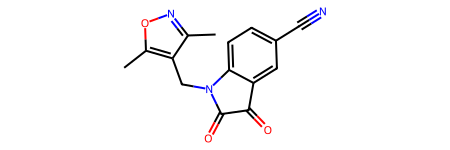

In [9]:
my_one_mol_object

In [10]:
Chem.MolToSmiles(my_one_mol_object)

'Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21'

In [11]:
Chem.MolToInchiKey(my_one_mol_object)

'AGHODQJTQBGFTA-UHFFFAOYSA-N'

In [12]:
my_one_mol_object.GetNumAtoms()

21

In [13]:
# Molecule representation
#https://en.wikipedia.org/wiki/Chemical_table_file#Extended_Connection_Table_(V3000)
print(Chem.MolToMolBlock(my_one_mol_object))


     RDKit          2D

 21 23  0  0  0  0  0  0  0  0999 V2000
   -2.2990    0.0563    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.5980   -0.6937    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.9684   -0.0836    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -5.9720   -1.1983    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -5.2220   -2.4973    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -5.8322   -3.8676    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.7548   -2.1855    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.6401   -3.1891    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2135   -2.7256    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000   -3.6073    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000   -5.1073    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.2135   -2.7256    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.6401   -3.1891    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0

In [29]:
from rdkit.Chem import AllChem
my_one_mol_object_3D = Chem.AddHs(my_one_mol_object) # by default rdkit's mol object does not store H's
AllChem.EmbedMolecule(my_one_mol_object_3D)

0

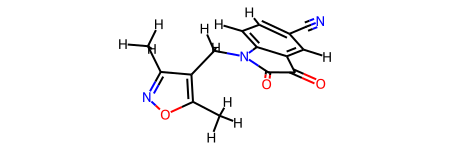

In [30]:
my_one_mol_object_3D

In [31]:
print(Chem.MolToMolBlock(my_one_mol_object_3D))


     RDKit          3D

 32 34  0  0  0  0  0  0  0  0999 V2000
   -3.6805    0.6888    2.2791 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.1198   -0.4382    1.5072 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.7306   -1.5404    1.0717 N   0  0  0  0  0  0  0  0  0  0  0  0
   -2.9181   -2.3035    0.4297 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7075   -1.7465    0.4012 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5409   -2.3551   -0.2539 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7765   -0.5551    1.0729 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7771    0.4869    1.3687 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5347    0.2405    0.8732 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.5821   -0.4537    1.5842 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5146   -0.9730    2.7337 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.7549   -0.4598    0.7459 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.8826   -0.9551    0.9768 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.3982    0.2482   -0

## write molecule to sdf file

In [32]:
w = Chem.SDWriter('./my_one_mol_object_3D.sdf')
w.write(my_one_mol_object_3D)
w.close()

In [ ]:
#Works only on Linux, just viewing plain text file my_one_mol_object_3D.sdf

In [33]:
%%bash
less ./my_one_mol_object_3D.sdf


     RDKit          3D

 32 34  0  0  0  0  0  0  0  0999 V2000
   -3.6805    0.6888    2.2791 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.1198   -0.4382    1.5072 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.7306   -1.5404    1.0717 N   0  0  0  0  0  0  0  0  0  0  0  0
   -2.9181   -2.3035    0.4297 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7075   -1.7465    0.4012 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5409   -2.3551   -0.2539 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7765   -0.5551    1.0729 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7771    0.4869    1.3687 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5347    0.2405    0.8732 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.5821   -0.4537    1.5842 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5146   -0.9730    2.7337 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.7549   -0.4598    0.7459 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.8826   -0.9551    0.9768 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.3982    0.2482   -0

# working with pandas dataframe

You could work with help of PandasTools module (easy to use, good for "small" data).
Or you could do everything on yourown (good when trying to deal with "big" data (like more than 100K molecules))

In [34]:
data_small = data.head(40).copy()

In [35]:
data_small.head()

,SMILES_STD,pX_adj,ACTIVE
0,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,1
1,O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21,4.756962,0
2,CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2,4.304518,0
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c5cc(=O)c...,4.432109,0
4,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1-c1c(O)cc...,4.117803,0


In [36]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(data_small, smilesCol='SMILES_STD',molCol='ROMol')


Failed to patch pandas - unable to change molecule rendering


In [37]:
data_small.head()

,SMILES_STD,pX_adj,ACTIVE,ROMol
0,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,1,<rdkit.Chem.rdchem.Mol object at 0x152cc9820>
1,O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21,4.756962,0,<rdkit.Chem.rdchem.Mol object at 0x152cc97b0>
2,CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2,4.304518,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9430>
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c5cc(=O)c...,4.432109,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9120>
4,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1-c1c(O)cc...,4.117803,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9890>


**important to know** ROMol is not a column with pictures, its column with Mol Objects, represented as pictures

In [38]:
# manual way
data_small["MolObj"] = data_small['SMILES_STD'].map(lambda x: Chem.MolFromSmiles(x))

In [39]:
data_small.head()

,SMILES_STD,pX_adj,ACTIVE,ROMol,MolObj
0,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,1,<rdkit.Chem.rdchem.Mol object at 0x152cc9820>,<rdkit.Chem.rdchem.Mol object at 0x152cc9350>
1,O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21,4.756962,0,<rdkit.Chem.rdchem.Mol object at 0x152cc97b0>,<rdkit.Chem.rdchem.Mol object at 0x152cd1a50>
2,CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2,4.304518,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9430>,<rdkit.Chem.rdchem.Mol object at 0x152cd1510>
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c5cc(=O)c...,4.432109,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9120>,<rdkit.Chem.rdchem.Mol object at 0x152cd19e0>
4,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1-c1c(O)cc...,4.117803,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9890>,<rdkit.Chem.rdchem.Mol object at 0x152cd1ac0>


why do we need manual way? Store Mol Objects **in memory could be hard**. so sometimes its useful to perform calculation of interest **on the fly**

In [40]:
# example of cacluclating n_atoms without storing MolObjects
data_small["n_Atoms"] = data_small['SMILES_STD'].map(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())

In [43]:
data_small.head()

,SMILES_STD,pX_adj,ACTIVE,ROMol,MolObj,n_Atoms
0,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5.142668,1,<rdkit.Chem.rdchem.Mol object at 0x152cc9820>,<rdkit.Chem.rdchem.Mol object at 0x152cc9350>,21
1,O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21,4.756962,0,<rdkit.Chem.rdchem.Mol object at 0x152cc97b0>,<rdkit.Chem.rdchem.Mol object at 0x152cd1a50>,26
2,CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2,4.304518,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9430>,<rdkit.Chem.rdchem.Mol object at 0x152cd1510>,21
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c5cc(=O)c...,4.432109,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9120>,<rdkit.Chem.rdchem.Mol object at 0x152cd19e0>,43
4,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1-c1c(O)cc...,4.117803,0,<rdkit.Chem.rdchem.Mol object at 0x152cc9890>,<rdkit.Chem.rdchem.Mol object at 0x152cd1ac0>,41


## Drawing a mol grid

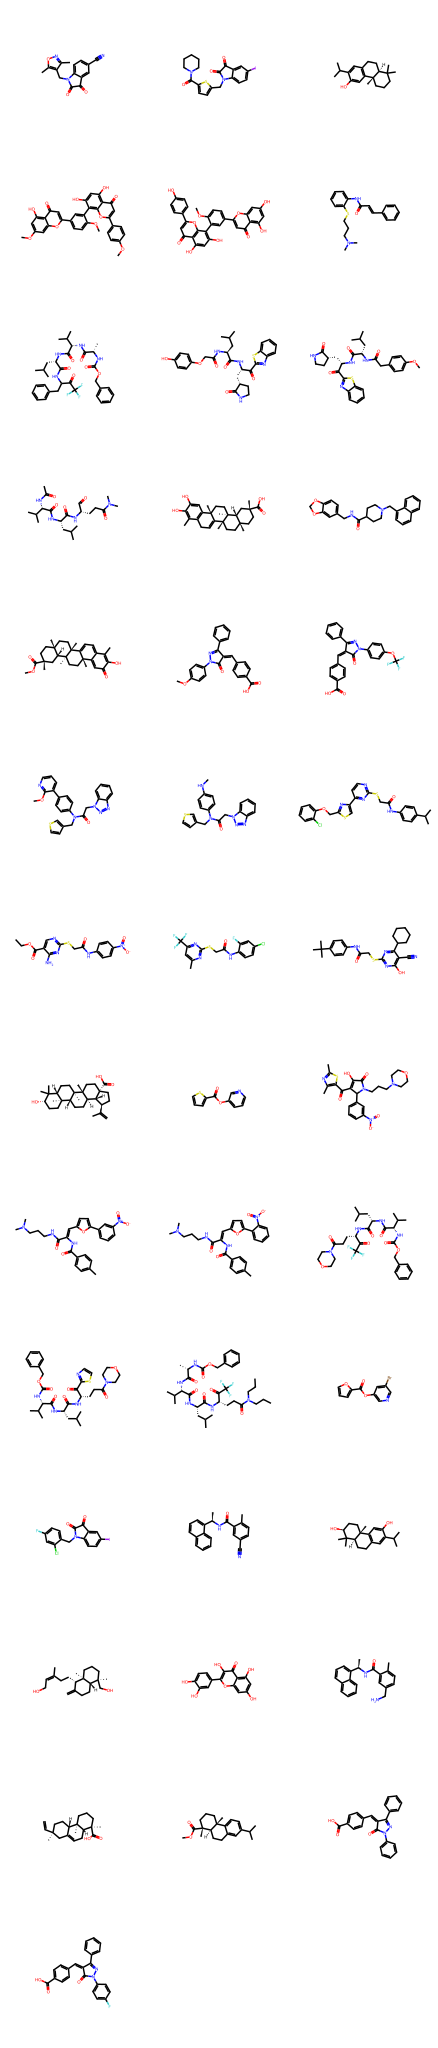

In [42]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(list(data_small.ROMol), useSVG=True)

# Molecular fingerprints

![img](./fp_list.png)

In [44]:
my_this_mol_obj = data_small["ROMol"][0]
my_that_mol_obj = data_small["ROMol"][1]

In [55]:
this_fp = Chem.RDKFingerprint(my_this_mol_obj,maxPath=7,fpSize=512)
that_fp = Chem.RDKFingerprint(my_that_mol_obj,maxPath=7,fpSize=512)

In [56]:
this_fp

In [57]:
that_fp.ToBitString()

'11111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111011111111111111111111111101111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111101111011111111111111111111111111111111111111111111111111111111110111111111111111111111111111111101111111111111111111111'

In [58]:
import numpy as np
np.array(that_fp)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In more details see this illustration from OpenEye documentation
![pathfp](./PathEnumeration.png)

In [59]:
# Morgan FP
MFP_this = AllChem.GetMorganFingerprint(my_this_mol_obj,2)
MFP_this

 In more details see this illustration from OpenEye documentation
![pathfp](./CircularEnumeration.png)

In [61]:
MFP_this_bits = AllChem.GetMorganFingerprintAsBitVect(my_this_mol_obj,5,nBits=512)
MFP_this_bits

In [62]:
MFP_this_bits.ToBitString()

'00000010001010101000000000000000010001000000000001000000000100010000000100001000100001000000100001000110000010001000000010000000010000000010001010000000000000000010000001000000000000000110000000010000000000000000101000001000000001000010000001000000100000000000000100000001000000100000000000011000000000010100000000100000010100000000000001000000000000001000100010010001000000000011000000000000000001000000000000000000001000010000000000000001000000000100100100000110000000000000000000000000000000000010000000000000'

In [63]:
DataStructs.DiceSimilarity(this_fp,this_fp)

1.0

In [64]:
DataStructs.DiceSimilarity(this_fp,that_fp)

0.9839679358717435

In [65]:
DataStructs.DiceSimilarity(this_fp,MFP_this_bits)

0.23172905525846701

## what does the bit means

In [66]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('c1ccccc1CC1CC1')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi,nBits=512)

mfp2_svg = Draw.DrawMorganBit(mol, 29, bi, useSVG=True)
rdkbi = {}
rdkfp = Chem.RDKFingerprint(mol, maxPath=5, bitInfo=rdkbi,fpSize=512)
rdk_svg = Draw.DrawRDKitBit(mol, 2, rdkbi, useSVG=True)

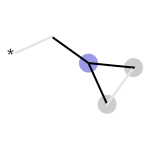

In [67]:
mfp2_svg

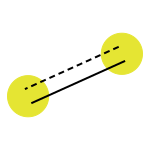

In [68]:
rdk_svg

## Molecular similarity

## Dice similarity

![dice](./dice_sim.png)

## Tanimoto similarity 

![tani](./jacard_sim.jpg)

In [47]:
from rdkit import DataStructs
# Tanimoto
commonBits = this_fp&that_fp
print('this:',this_fp.GetNumOnBits(),'that:',that_fp.GetNumOnBits(),'num in common:',commonBits.GetNumOnBits())
print(commonBits.GetNumOnBits()/(this_fp.GetNumOnBits()+that_fp.GetNumOnBits()-commonBits.GetNumOnBits()))
print('Tanimoto:', DataStructs.TanimotoSimilarity(this_fp,that_fp))

this: 496 that: 502 num in common: 491
0.9684418145956607
Tanimoto: 0.9684418145956607


In [48]:
from sklearn.metrics import jaccard_score

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
jaccard_score(np.array(this_fp),np.array(that_fp))

## molecular similarity visualization 

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps


In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(my_this_mol_obj,my_that_mol_obj, SimilarityMaps.GetMorganFingerprint)


In [ ]:
Draw.MolsToGridImage([my_this_mol_obj,my_that_mol_obj])

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(my_this_mol_obj, my_that_mol_obj,
                                                               lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=5, fpType='bv'),
                                                               metric=DataStructs.TanimotoSimilarity)


## On a bigger scale with pandas dataframe 

In [ ]:
def SMI2FD(smiles_str,mP=7,fS=1024):
    fp = Chem.RDKFingerprint(Chem.MolFromSmiles(smiles_str),maxPath=mP,fpSize=fS)
    return np.array(fp)
data_small["RDKFP"]=data_small["SMILES_STD"].apply(SMI2FD)

In [ ]:
data_small.head(1)

In [ ]:
first_fp = data_small["RDKFP"][0]

In [ ]:
data_small["Tanimoto_sim_toFirst"]=data_small["RDKFP"].apply(lambda x: jaccard_score(x,first_fp))

In [ ]:
data_small.sort_values(['Tanimoto_sim_toFirst'], inplace=False, ascending=False)

## Descriptors

![desc](./de_list.png)

In [ ]:
from rdkit.Chem import Descriptors
print("TPSA %s"%Descriptors.TPSA(my_this_mol_obj))
print("mollogP %s"%Descriptors.MolLogP(my_this_mol_obj))

In [ ]:
from rdkit.Chem import rdMolDescriptors
contribs = rdMolDescriptors._CalcCrippenContribs(my_this_mol_obj)
fig = SimilarityMaps.GetSimilarityMapFromWeights(my_this_mol_obj,[x for x,y in contribs], colorMap='jet', contourLines=10)


In [ ]:
# how to calculate them all

In [ ]:

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
nms=[x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(nms)
print(len(nms))

In [ ]:
my_precious_descs = [calc.CalcDescriptors(x) for x in [my_this_mol_obj,my_that_mol_obj]]
my_precious_descs

In [ ]:
np.array(my_precious_descs).shape

In [ ]:
from sklearn.metrics import euclidean_distances
euclidean_distances(np.array(my_precious_descs))

For realworld data for descriptor calculation one of the most common used library is [Mordred Descriptors](https://github.com/mordred-descriptor/mordred) (~ 1500 descriptors)

## Substructure search

In [ ]:
benzo_six = Chem.MolFromSmarts('[*r6R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r6R1][*r6R1][*r6R1]1')

In [ ]:
benzo_six

In [ ]:
data_small[data_small['ROMol'] >= benzo_six][['ROMol']]

In [ ]:
data_small["ROMol"].apply(lambda x: x.HasSubstructMatch(benzo_six) )

In [ ]:
data_small["HasBenzoSix"]=data_small["ROMol"].apply(lambda x: x.HasSubstructMatch(benzo_six) )

In [ ]:

highlight_lists = [mol.GetSubstructMatch(benzo_six) for mol in data_small["ROMol"].to_list()]
Draw.MolsToGridImage(data_small["ROMol"].to_list(), 
                     highlightAtomLists = highlight_lists,
                     useSVG=False
                    )

In [ ]:
highlight_lists = [mol.GetSubstructMatch(benzo_six) for mol in data_small[data_small["HasBenzoSix"]]["ROMol"].to_list()]
Draw.MolsToGridImage(data_small[data_small["HasBenzoSix"]]["ROMol"].to_list(), 
                     highlightAtomLists = highlight_lists,
                     useSVG=False
                    )

In [ ]:
AllChem.Compute2DCoords(benzo_six)

In [ ]:
for mol in data_small[data_small["HasBenzoSix"]]["ROMol"].to_list():
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_six, acceptFailure = True)

In [ ]:
highlight_lists = [mol.GetSubstructMatch(benzo_six) for mol in data_small[data_small["HasBenzoSix"]]["ROMol"].to_list()]
Draw.MolsToGridImage(data_small[data_small["HasBenzoSix"]]["ROMol"].to_list(), 
                     highlightAtomLists = highlight_lists,
                     useSVG=False
                    )

## Murko scaffolds

In [ ]:
from rdkit.Chem.Scaffolds import MurckoScaffold
core = MurckoScaffold.GetScaffoldForMol(my_this_mol_obj)

In [ ]:
Draw.MolsToGridImage([core,my_this_mol_obj,my_that_mol_obj])

In [ ]:
fw = MurckoScaffold.MakeScaffoldGeneric(core)
Chem.MolToSmiles(fw)


In [ ]:
Draw.MolsToGridImage([fw,core,my_this_mol_obj],legends=["generic scaffold","scaffold","molecule"])

In [ ]:
AllChem.Compute2DCoords(core)


In [ ]:
for m in [core,my_this_mol_obj]:
    AllChem.GenerateDepictionMatching2DStructure(m,core)

In [ ]:
Draw.MolsToGridImage([core,my_this_mol_obj],legends=["scaffold","molecule"])